# Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import subprocess
import seaborn as sns
import seaborn.objects as so
from glob2 import glob

In [2]:
import mir_eval as me

In [3]:
dcml_chordtype_map = {
    "M": "major",
    "m": "minor",
    "Mm7": "dominant-7th",
    "o": "diminished",
    "o7": "full-diminished",
    "mm7": "minor-7th",
    "%7": "half-diminished",
    "MM7": "major-7th",
    "+": "augmented",
    "mM7": "minor-major-7th",
    "+7": "augmented-7th",
}

----

## Loading the Results
Loads all json files from the given folders

In [141]:
cols = ['id', 'corpus', 'piece', 'algorithm', 'accuracy', 'likelihood', 'chordLabels', 'slices','runTime', 'reruns']

In [185]:
def load_dataset(path):
    jsonFiles = glob(path + '/*/*/*/*.json')
    df = pd.DataFrame(columns=cols) 
    lbls = pd.DataFrame(columns=["piece", "corpus", "labels"])
    fails = []
    successes = 0
    for jsonFile in jsonFiles:
        try:
            with open(jsonFile, 'r') as f:
                data = json.loads(f.read())
        except:
            fails.append(jsonFile)
            continue
        successes += 1

        newLbls = pd.DataFrame([{"corpus":data['corpus'], "piece":data["piece"], "labels": data["groundTruth"]}])
        lbls = pd.concat([lbls, newLbls])

        newdf = pd.json_normalize(data, record_path = ['results'], 
            meta = ['id','corpus', 'piece','algorithm'])
        
        
        
        #newdf['groundTruth']= data['groundTruth']
        df = pd.concat([df, newdf])
    
    #results["experiment"] = results.index.get_level_values(0)
    df["experiment"] = df["id"].apply(lambda x: x.split("_")[1] if "_" in x else np.nan)
    df["id"] = df["id"].apply(lambda x: x.split("_")[0] if "_" in x else np.nan)
    df = df.dropna(subset=["experiment"])
    results = df.set_index(["experiment","id","corpus", "piece"])
    print ("Parsed {} runs succesfully, consisting of {} unique experiments with {} failed runs".format(successes, results.index.levels[0].nunique(), len(fails)))
    return (results,lbls.set_index(["corpus", "piece"]))

Load all runs - takes ~20s

In [186]:
(results,groundTruth) = load_dataset("outputs")

Parsed 536 runs succesfully, consisting of 1 unique experiments with 303 failed runs


# Organising results

In [189]:
results.dropna(subset="accuracy")

algorithm  \
experiment id               corpus             piece                    
beamwidth  202304-1617-4112 grieg_lyric_pieces op12n08  BeamSearch_14   
                                               op12n08  BeamSearch_19   
                                               op12n08  BeamSearch_15   
                                               op12n08   BeamSearch_8   
                                               op12n08   BeamSearch_5   
                                               op12n08  BeamSearch_17   
                                               op12n08  BeamSearch_12   
                                               op12n08  BeamSearch_10   
                                               op12n08  BeamSearch_16   
                                               op12n08   BeamSearch_6   
                                               op12n08  BeamSearch_13   
                                               op12n08   BeamSearch_4   
                                               op12n08  BeamSearch_18   
                                               op12n08   BeamSearch_1   
                                               op12n08   BeamSearch_7   
                                               op12n08   BeamSearch_2   
                                               op12n08  BeamSearch_11   
                                               op12n08   BeamSearch_9   
                                               op12n08   BeamSearch_3   
                                               op38n06  BeamSearch_14   
                                               op38n06  BeamSearch_15   
                                               op38n06  BeamSearch_12   
                                               op38n06  BeamSearch_10   
                                               op38n06  BeamSearch_16   
                                               op38n06  BeamSearch_13   
                                               op38n06  BeamSearch_11   
                                               op12n01  BeamSearch_14   
                                               op12n01  BeamSearch_19   
                                               op12n01  BeamSearch_15   
                                               op12n01   BeamSearch_8   
                                               op12n01   BeamSearch_5   
                                               op12n01  BeamSearch_17   
                                               op12n01  BeamSearch_12   
                                               op12n01  BeamSearch_10   
                                               op12n01  BeamSearch_16   
                                               op12n01   BeamSearch_6   
                                               op12n01  BeamSearch_13   
                                               op12n01   BeamSearch_4   
                                               op12n01  BeamSearch_18   
                                               op12n01   BeamSearch_1   
                                               op12n01   BeamSearch_7   
                                               op12n01   BeamSearch_2   
                                               op12n01  BeamSearch_11   
                                               op12n01   BeamSearch_9   
                                               op12n01   BeamSearch_3   

                                                        accuracy  likelihood  \
experiment id               corpus             piece                           
beamwidth  202304-1617-4112 grieg_lyric_pieces op12n08  0.756410  -12.465096   
                                               op12n08  0.756410  -12.465096   
                                               op12n08  0.756410  -12.465096   
                                               op12n08  0.756410  -12.465096   
                                               op12n08  0.756410  -12.465096   
                                               op12n08  0.756410  -1

In [144]:
#print(" ".join(list(results.index.levels[2].unique())))

In [177]:
results

algorithm  \
id                         corpus             piece                         
202304-1616-5325_beamwidth ABC                n08op59-2_03  BeamSearch_14   
                                              n08op59-2_03  BeamSearch_19   
                                              n08op59-2_03  BeamSearch_15   
                                              n08op59-2_03  BeamSearch_17   
                                              n08op59-2_03  BeamSearch_16   
...                                                                   ...   
202304-1617-4112_beamwidth grieg_lyric_pieces op12n01        BeamSearch_7   
                                              op12n01        BeamSearch_2   
                                              op12n01       BeamSearch_11   
                                              op12n01        BeamSearch_9   
                                              op12n01        BeamSearch_3   

                                                            accuracy  \
id                         corpus             piece                    
202304-1616-5325_beamwidth ABC                n08op59-2_03       NaN   
                                              n08op59-2_03       NaN   
                                              n08op59-2_03       NaN   
                                              n08op59-2_03       NaN   
                                              n08op59-2_03       NaN   
...                                                              ...   
202304-1617-4112_beamwidth grieg_lyric_pieces op12n01       0.325581   
                                              op12n01       0.325581   
                                              op12n01       0.325581   
                                              op12n01       0.325581   
                                              op12n01       0.325581   

                                                            likelihood  \
id                         corpus             piece                      
202304-1616-5325_beamwidth ABC                n08op59-2_03         NaN   
                                              n08op59-2_03         NaN   
                                              n08op59-2_03         NaN   
                                              n08op59-2_03         NaN   
                                              n08op59-2_03         NaN   
...                                                                ...   
202304-1617-4112_beamwidth grieg_lyric_pieces op12n01       -13.610732   
                                              op12n01       -13.610732   
                                              op12n01       -13.610732   
                                              op12n01       -13.610732   
                                              op12n01       -13.610732   

                                                                                                  chordLabels  \
id                         corpus             piece                                                             
202304-1616-5325_beamwidth ABC                n08op59-2_03                                               None   
                                              n08op59-2_03                                               None   
                                              n08op59-2_03                                               None   
                                              n08op59-2_03                                               None   
                                              n08op59-2_03                                               None   
...                                                                                                       ...   
202304-1617-4112_beamwidth grieg_lyric_pieces op12n01       [E♭M, E♭M, A♭M, A♭m, E♭M, E♭M, E♭M, Cm, Gm, CM...   
                                              op12n01       [E♭M, E♭M, A♭M, A♭m, E♭M, E♭M, E♭M, Cm, Gm, CM...   
                                

In [157]:
results

algorithm  \
id                                                 corpus          piece                            
202304-1615-1815-a93d54f4-39ee-4d28-999e-27efc6... ABC             n05op18-5_01   RandomReduction   
                                                                   n05op18-5_01      RandomSample   
                                                                   n05op18-5_01        RandomWalk   
                                                                   n11op95_03     RandomReduction   
                                                                   n11op95_03        RandomSample   
...                                                                                           ...   
                                                   chopin_mazurkas BI61-5op07-5      RandomSample   
                                                                   BI61-5op07-5        RandomWalk   
                                                                   BI162-3op63-3  RandomReduction   
                                                                   BI162-3op63-3     RandomSample   
                                                                   BI162-3op63-3       RandomWalk   

                                                                                  accuracy  \
id                                                 corpus          piece                     
202304-1615-1815-a93d54f4-39ee-4d28-999e-27efc6... ABC             n05op18-5_01   0.334112   
                                                                   n05op18-5_01   0.002336   
                                                                   n05op18-5_01   0.558411   
                                                                   n11op95_03     0.280556   
                                                                   n11op95_03     0.016667   
...                                                                                    ...   
                                                   chopin_mazurkas BI61-5op07-5   0.026316   
                                                                   BI61-5op07-5   0.710526   
                                                                   BI162-3op63-3  0.146341   
                                                                   BI162-3op63-3  0.000000   
                                                                   BI162-3op63-3  0.243902   

                                                                                  likelihood  \
id                                                 corpus          piece                       
202304-1615-1815-a93d54f4-39ee-4d28-999e-27efc6... ABC             n05op18-5_01   -13.341290   
                                                                   n05op18-5_01   -15.184658   
                                                                   n05op18-5_01   -12.645643   
                                                                   n11op95_03     -13.218597   
                                                                   n11op95_03     -15.415670   
...                                                                                      ...   
                                                   chopin_mazurkas BI61-5op07-5   -16.344830   
                                                                   BI61-5op07-5   -12.879186   
                                                                   BI162-3op63-3  -13.239494   
                                                                   BI162-3op63-3  -15.921198   
                                                                   BI162-3op63-3  -12.336454   

                                                                                                                        chordLabels  \
id                                                 corpus          piece                                                              
202304-1615-1815-a93d54f4-39ee-4

# Analysis on latest experiment

In [122]:
results=experimentResults[experiments[1]].reset_index()

In [123]:
results = results.drop(["id"],axis=1)

In [124]:
results.drop(["chordLabels", "slices"], axis=1).groupby(["algorithm"]).agg([np.mean, np.std])

/tmp/ipykernel_447367/71810194.py:1: FutureWarning: ['corpus', 'piece'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  results.drop(["chordLabels", "slices"], axis=1).groupby(["algorithm"]).agg([np.mean, np.std])


accuracy           likelihood              runTime  \
                     mean       std       mean       std       mean   
algorithm                                                             
RandomReduction  0.303849  0.093321 -13.238497  0.229436   0.070391   
RandomSample     0.019205  0.017911 -15.239635  0.367816   0.001149   
RandomWalk       0.415769  0.151907 -13.186622  0.619841  49.319015   

                           reruns      reRuns      
                       std   mean  std   mean std  
algorithm                                          
RandomReduction   0.237469    1.0  0.0    NaN NaN  
RandomSample      0.005116    1.0  0.0    NaN NaN  
RandomWalk       94.198655    1.0  0.0    NaN NaN

In [125]:
agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).agg([np.mean, np.std])

/tmp/ipykernel_447367/900570239.py:1: FutureWarning: ['piece'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  agm = results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).agg([np.mean, np.std])


In [126]:
#results.drop(["chordLabels", "slices"], axis=1).groupby(["corpus", "algorithm"]).errors()

In [131]:
agm = results.drop(["chordLabels", "slices","runTime","likelihood","piece"], axis=1).groupby(["corpus", "algorithm"]).agg([np.std])

In [132]:
errs = agm.reset_index()["accuracy"]["std"].fillna(0)

In [133]:
a = results.drop(["chordLabels", "slices"], axis=1)

In [134]:
std_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.std)

In [135]:
acc_pivot = pd.pivot_table(a, 
                          values="accuracy", 
                          index="corpus", 
                          columns="algorithm", 
                          aggfunc=np.mean)

## Plot Accuracy Chart

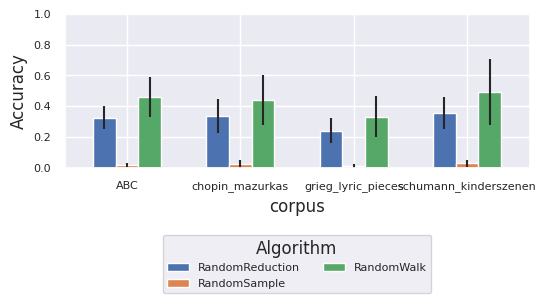

In [136]:
sns.set()  # use Seaborn styles
acc_pivot.plot.bar(yerr=std_pivot, figsize=(6,2), fontsize=8, rot=0, ylim=(0,1), width=0.6, legend="loc:lower center")
plt.ylabel('Accuracy')
plt.legend(loc='upper center', title="Algorithm", bbox_to_anchor=(0.5, -0.4),
          fancybox=True, ncol=2, prop={'size': 8})
          

<BarContainer object of 4 artists>

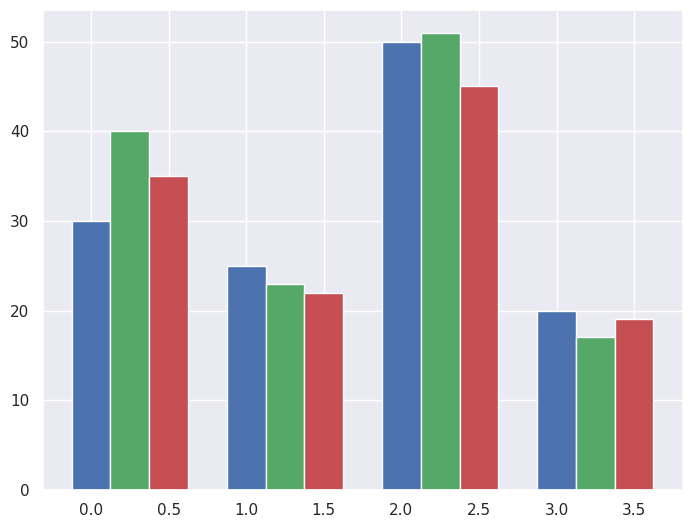

In [137]:
data = [[30, 25, 50, 20],
[40, 23, 51, 17],
[35, 22, 45, 19]]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

# Close Error Analysis

Attributes: chord type, root note, etc

#### Zoom in on ABC: n02op18-2_03

In [138]:
groundTruth.loc['ABC','n02op18-2_03']

/tmp/ipykernel_447367/3143486535.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  groundTruth.loc['ABC','n02op18-2_03']


labels
corpus piece                                                          
ABC    n02op18-2_03  [GM, DMm7, GM, DM, DM, DMm7, DMm7, GM, Am, DMm...
       n02op18-2_03  [GM, DMm7, GM, DM, DM, DMm7, DMm7, GM, Am, DMm...
       n02op18-2_03  [GM, DMm7, GM, DM, DM, DMm7, DMm7, GM, Am, DMm...
       n02op18-2_03  [GM, DMm7, GM, DM, DM, DMm7, DMm7, GM, Am, DMm...

In [139]:
results

,corpus,piece,algorithm,accuracy,likelihood,chordLabels,slices,runTime,reruns,reRuns
0,ABC,n05op18-5_01,RandomReduction,0.334112,-13.341290,"[AM, AM, DM, AM, DM, AM, DM, EM, EM, DM, AM, A...","[[E5, E4, C♯6, A6, A6], [D6, C♯5, A6, A6], [D5...",0.015810,1,NaN
1,ABC,n05op18-5_01,RandomSample,0.002336,-15.184658,"[DM, E♭M, C♭M, E♭M, B♭M, GM, A♭M, GM, C♭M, F♯M...","[[D3, B7, C♯11, A4, F-2], [A♭-7, E6, B7, B♭-4,...",0.000369,1,NaN
2,ABC,n05op18-5_01,RandomWalk,0.558411,-12.645643,"[AM, AM, DM, EMm7, AM, AMm7, DM, EM, EMm7, AM,...","[[E5, C♯5, B5, A5, A5, G♯5, A4], [D6, E5, E4, ...",29.500378,1,NaN
3,ABC,n11op95_03,RandomReduction,0.280556,-13.218597,"[Bo, CM, FM, CM, B♭Mm7, GM, E♭M, Cm, CM, FM, F...","[[D6, D6, D6, F5, B4], [C5, C6], [F5, F5, F5, ...",0.019908,1,NaN
4,ABC,n11op95_03,RandomSample,0.016667,-15.415670,"[EMm7, EGer, B♭M, C♯Mm7, Bo, BM, AM, GMm7, F♯o...","[[D3, E6, C♭-11, B7, A4], [E6, G♭-10, B7, C♭-1...",0.000481,1,NaN
...,...,...,...,...,...,...,...,...,...,...
344,chopin_mazurkas,BI61-5op07-5,RandomSample,0.026316,-16.344830,"[E♭M, CM, B♭+, E♭M, FMm7, G♭M, A♭M, AM, G♭M, B...","[[C♭-11, G1, F-2], [G♭-10, E6, C0, C0], [G♭-10...",0.000348,1,NaN
345,chopin_mazurkas,BI61-5op07-5,RandomWalk,0.710526,-12.879186,"[GM, GMm7, CM, GMm7, CM, GMm7, GMm7, CM, CM, C...","[[G3, G4], [D6, F5, B4, G4], [E5, C5, G4, G5],...",1.733942,1,NaN
346,chopin_mazurkas,BI162-3op63-3,RandomReduction,0.146341,-13.239494,"[AM, C♯M, F♯M, EM, D♯Mm7, C♯M, D♯M, G♯Mm7, C♯m...","[[E5, A5], [C♯5, C♯5, C♯6, G♯4], [C♯6, F♯5, D♯...",0.001410,1,NaN
347,chopin_mazurkas,BI162-3op63-3,RandomSample,0.000000,-15.921198,"[D♭M, G♭M, F♯m, E♭M, AM, Eo7, Do7, E♭M, B♭M, A...","[[D♭-8, D♭-8], [B♭-4, D♭-8], [C♯11, A4, F♯9], ...",0.000300,1,NaN


In [140]:
ex = results.loc['schumann_kinderszenen','n04']

KeyError: 'n04'

In [ ]:
ex[["algorithm", "accuracy", "likelihood", "runTime"]]

algorithm  accuracy    likelihood   runTime
corpus                piece                                                   
schumann_kinderszenen n04        RandomParse  0.660377 -1.494140e+01  0.004168
                      n04        RandomParse  0.660377 -1.493340e+01  0.001612
                      n04        RandomParse  0.660377 -1.493801e+01  0.001478
                      n04        RandomParse  0.660377 -1.494140e+01  0.003723
                      n04        RandomParse  0.660377 -1.494145e+01  0.001646
                      n04     RandomParseSBS  0.584906 -1.434172e+01  0.016878
                      n04     RandomParseSBS  0.622642 -1.444055e+01  0.014206
                      n04     RandomParseSBS  0.584906 -1.430832e+01  0.017524
                      n04     RandomParseSBS  0.566038 -1.418231e+01  0.015672
                      n04     RandomParseSBS  0.547170 -1.442265e+01  0.016779
                      n04    RandomSampleSBS  0.320755 -1.432721e+01  0.000364
                      n04    RandomSampleSBS  0.301887 -1.465992e+01  0.000351
                      n04    RandomSampleSBS  0.377358 -1.427180e+01  0.000307
                      n04    RandomSampleSBS  0.396226 -1.465982e+01  0.000338
                      n04    RandomSampleSBS  0.320755 -1.415998e+01  0.000433
                      n04       RandomSample  0.037736 -1.132077e+07  0.000388
                      n04       RandomSample  0.037736 -7.547191e+06  0.000314
                      n04       RandomSample  0.000000 -9.433983e+06  0.000327
                      n04       RandomSample  0.018868 -1.320757e+07  0.000304
                      n04       RandomSample  0.018868 -1.320757e+07  0.000303
                      n04         Heuristic1  0.660377 -1.494602e+01  0.413173
                      n04      HeuristicSBS1  0.622642 -1.460816e+01  0.414403